# Tests of old and new rsoopic cross section models for electron-impact ionization of $H_2$

Directly call rsoopic.h2crosssections methods and try to determine if the output is correct

In [1]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, e, m_e
import rsoopic.h2crosssections as h2crosssections
# Since PYTHONPATH is ignored, modify sys.path directly...
#sys.path.insert(1, '/home/vagrant/jupyter/rsoopic/rsoopic')
#import h2crosssections
import random

# Warp
# Origin date: Mon, 2 Jul 2018 16:00:48 -0600
# Local date: Mon, 2 Jul 2018 16:00:48 -0600
# Commit hash: b464829
# /home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/warp/warp.pyc
# /home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/warp/warpC.so
# Wed Sep 19 22:24:27 2018
# import warp time 0.513724088669 seconds
# For more help, type warphelp()


## Plot old and new cross sections and compare with Moller

The existing rsoopic cross section is using Rudd's BEB model, which is non-relativistic. A new, relativistic cross section has been implemented in the rsoopic branch RelativisticIonization01, using Kim's RBEB model (ref. in the source code). The simple Moller model (not valid close to the threshold ionization energy, but useful for benchmarking) was also implemented.

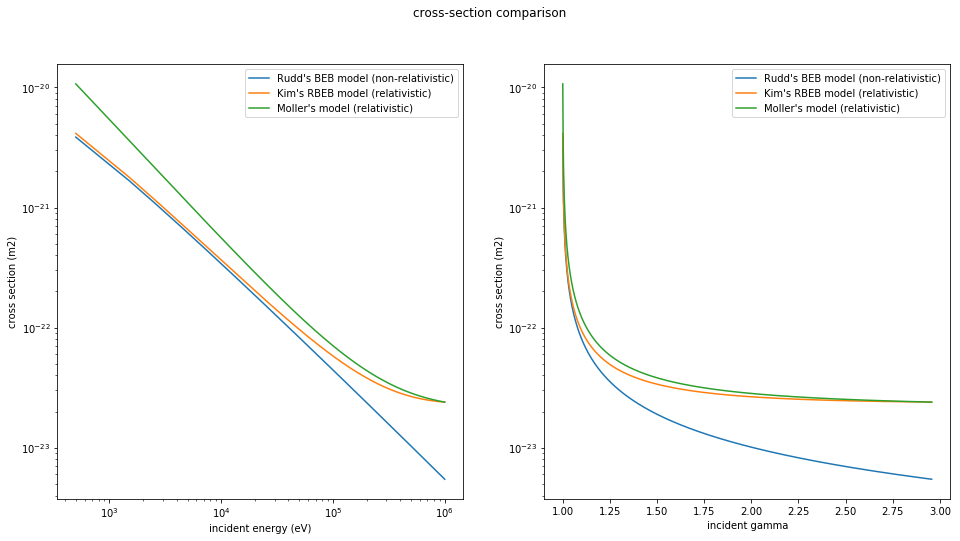

In [2]:
Tmax = 1.e6 # maximal incident energy (in eV)
n = 1000
T = np.linspace(.5 / n * Tmax, (1. - .5 / n) * Tmax, n) # incident energy in eV
gamma = e * T / (m_e * c**2) + 1.
v_T = c * np.sqrt(1. - np.divide(1., gamma**2))

sigma = np.empty((n))
for i in range(n):
 sigma[i] = h2crosssections.h2_ioniz_crosssection(v_T[i])

#plt.figure(figsize=(16,8))

Xsect_fig_0, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 8))

plt.suptitle('cross-section comparison')

ax1.plot(T, sigma, label='Rudd\'s BEB model (non-relativistic)')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('incident energy (eV)')
ax1.set_ylabel('cross section (m2)')
ax2.plot(gamma, sigma, label='Rudd\'s BEB model (non-relativistic)')
ax2.set_yscale('log')
ax2.set_xlabel('incident gamma')
ax2.set_ylabel('cross section (m2)')

# load module with updated version
sys.path.insert(1, '/home/vagrant/jupyter/rsoopic/rsoopic')
import h2crosssections
for i in range(n):
 sigma[i] = h2crosssections.h2_ioniz_crosssection(v_T[i])

ax1.plot(T, sigma, label='Kim\'s RBEB model (relativistic)')
ax2.plot(gamma, sigma, label='Kim\'s RBEB model (relativistic)')

h2crosssections.useMollerApproximation = True
for i in range(n):
 sigma[i] = h2crosssections.h2_ioniz_crosssection(v_T[i])

ax1.plot(T, sigma, label='Moller\'s model (relativistic)')
ax2.plot(gamma, sigma, label='Moller\'s model (relativistic)')

ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
plt.savefig('Xsect_analysis0.png')
plt.show()

Comments: rsoopic old, non-relativistic (Rudd's BEB) and new, relativistic (Kim's RBEB) cross sections agree up to tens of keV, as they should. At high energies RBEB converges with Moller, as it should, but only after I dialed in the cutoff energy $\epsilon_{min} = 1.2$ eV.

## Plot energy spectrum and angular distribution

Call rsoopic.h2crosssections.ejectedEnergy and generateAngle to check that the energy spectrum and angular distribution, respectively, of emitted electrons look OK. Unit tests will later be developed based on the code snippets below.

Spent 0.001 s generating ejected energies
max. particle energy:  2033.1817402136573  eV


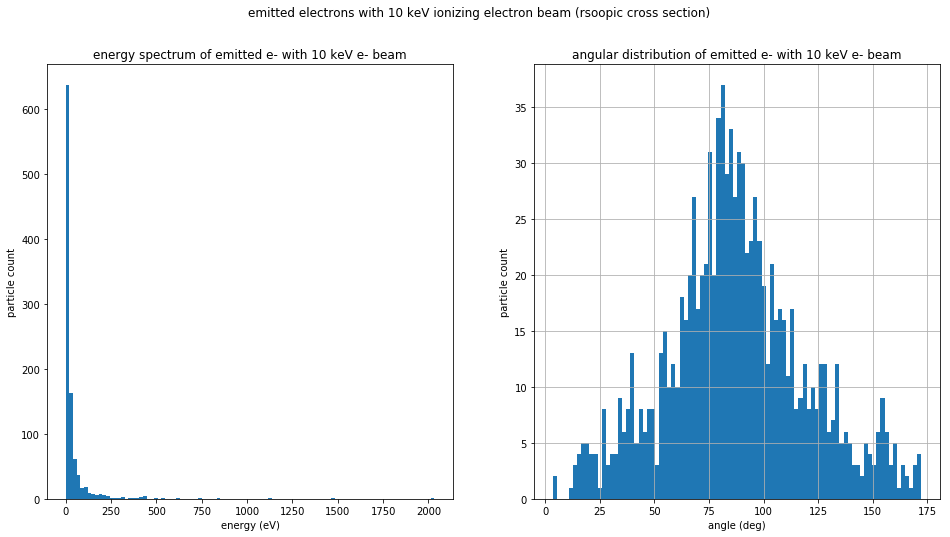

In [3]:
# Switch back from Moller to RBEB
h2crosssections.useMollerApproximation = False

gamma = lambda v: math.sqrt(1./(1.-v*v/(c*c)))
#for i in range(10):
#    beta = 0.1949 + 0.00001 * i
#    v = beta * c
#    print i, beta, m_e * c * c * (gamma(v) - 1.) / e

#sys.exit(0)

#beta = 0.06247 # for 1 keV kinetic energy
beta = 0.19499 # for 10 keV kinetic energy
n = 1000
v = np.full((n), beta * c)

energy = h2crosssections.ejectedEnergy(v, n)
print 'max. particle energy: ', energy.max(), ' eV'

eps = np.full((n), m_e * c * c * (gamma(beta * c) - 1.) / e) # incident energy in eV
angle = h2crosssections.generateAngle(n, energy, eps)
angle *= 180. / math.pi

Xsect_fig_1, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 8))

plt.suptitle('emitted electrons with 10 keV ionizing electron beam (rsoopic cross section)')

ax1.hist(energy, 100)
ax1.set_title('energy spectrum of emitted e- with 10 keV e- beam')
ax1.set_xlabel('energy (eV)')
ax1.set_ylabel('particle count')
ax2.hist(angle, 90)
ax2.set_title('angular distribution of emitted e- with 10 keV e- beam')
ax2.set_xlabel('angle (deg)')
ax2.set_ylabel('particle count')
ax2.grid(True)\
        
plt.savefig('Xsect_analysis1.png')
plt.show()

### Moller cross section

Implementation of pure Moller cross section for comparison (this was done before Moller was added rsoopic)

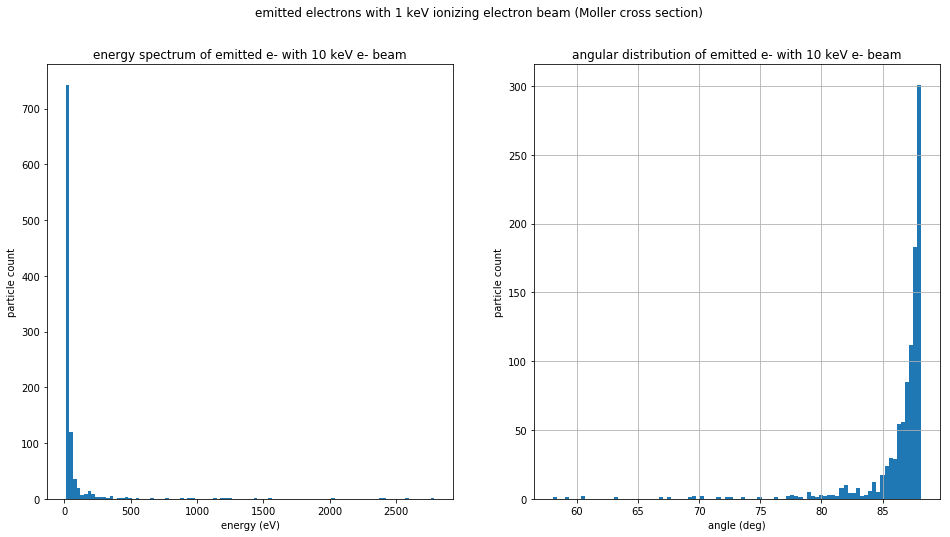

In [4]:
eps_min = 10. # value picked to give good agreement with rsoopic cross section results above
Ce = 2.0 * m_e * c * c / e

for i in range(n):
    Xrand = random.random()
    energy[i] = eps[i] * eps_min / (eps[i] - Xrand * (eps[i] - 2 * eps_min))
    costheta = energy[i] * (eps[i] + Ce)
    costheta /= eps[i] * (energy[i] + Ce)
    costheta = math.sqrt(costheta)
    angle[i] = 180. / math.pi * math.acos(costheta)

Xsect_fig_2, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 8))

plt.suptitle('emitted electrons with 1 keV ionizing electron beam (Moller cross section)')

ax1.hist(energy, 100)
ax1.set_title('energy spectrum of emitted e- with 10 keV e- beam')
ax1.set_xlabel('energy (eV)')
ax1.set_ylabel('particle count')
ax2.hist(angle, 90)
ax2.set_title('angular distribution of emitted e- with 10 keV e- beam')
ax2.set_xlabel('angle (deg)')
ax2.set_ylabel('particle count')
ax2.grid(True)
plt.savefig('Xsect_analysis2.png')
plt.show()

Comments: The emitted-electron energy spectrum with the existing rsoopic cross section is in good agreement with Moller at 1keV incident energy, but the angular distribution is much broader

### Angular spread isolated

Calculate angular distribution with both incident and emitted energy held fix, to see where the angular spread is coming from

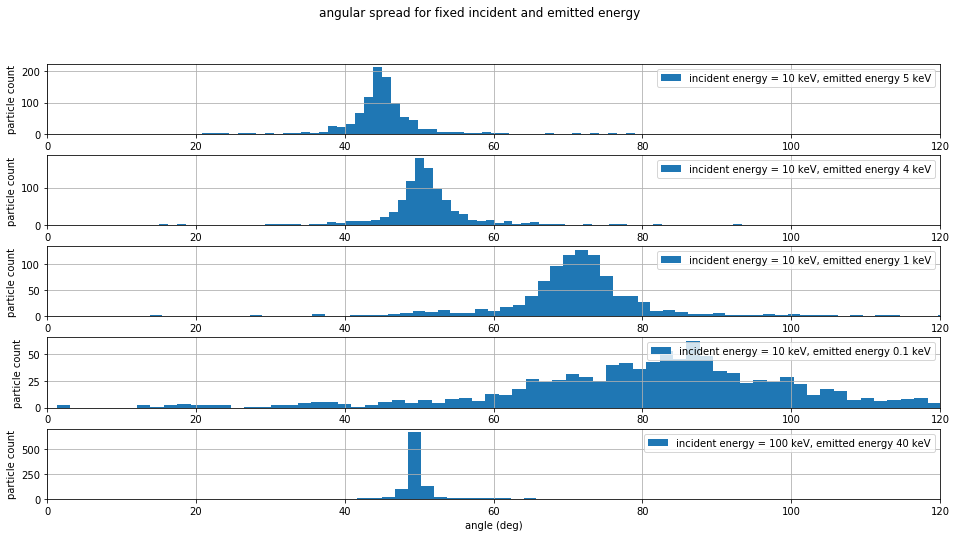

In [5]:
Xsect_fig_3, axes = plt.subplots(5, 1, figsize=(16, 8))
plt.suptitle('angular spread for fixed incident and emitted energy')

angle = 180. / math.pi * h2crosssections.generateAngle(n, 0.5 * eps, eps)
axes[0].hist(angle, 90, label='incident energy = 10 keV, emitted energy 5 keV')
#axes[0].set_title('emitted energy = 50% of incident energy')
axes[0].set_xlabel('angle (deg)')
axes[0].set_ylabel('particle count')
axes[0].grid(True)
axes[0].set_xlim([0, 120])

angle = 180. / math.pi * h2crosssections.generateAngle(n, 0.4 * eps, eps)
axes[1].hist(angle, 90, label='incident energy = 10 keV, emitted energy 4 keV')
#axes[1].set_title('emitted energy = 40% of incident energy')
axes[1].set_xlabel('angle (deg)')
axes[1].set_ylabel('particle count')
axes[1].grid(True)
axes[1].set_xlim([0, 120])

angle = 180. / math.pi * h2crosssections.generateAngle(n, 0.1 * eps, eps)
axes[2].hist(angle, 90, label='incident energy = 10 keV, emitted energy 1 keV')
#axes[2].set_title('emitted energy = 20% of incident energy')
axes[2].set_xlabel('angle (deg)')
axes[2].set_ylabel('particle count')
axes[2].grid(True)
axes[2].set_xlim([0, 120])

angle = 180. / math.pi * h2crosssections.generateAngle(n, 0.01 * eps, eps)
axes[3].hist(angle, 90, label='incident energy = 10 keV, emitted energy 0.1 keV')
#axes[3].set_title('emitted energy = 1% of incident energy')
axes[3].set_xlabel('angle (deg)')
axes[3].set_ylabel('particle count')
axes[3].grid(True)
axes[3].set_xlim([0, 120])

angle = 180. / math.pi * h2crosssections.generateAngle(n, 4. * eps, 10. * eps)
axes[4].hist(angle, 90, label='incident energy = 100 keV, emitted energy 40 keV')
#axes[4].set_title('emitted energy = 40% of incident energy of 1 MeV')
axes[4].set_xlabel('angle (deg)')
axes[4].set_ylabel('particle count')
axes[4].grid(True)
axes[4].set_xlim([0, 120])

# increase the vertical spacing between plots
plt.subplots_adjust(hspace=0.3)
for i in range(5):
    axes[i].legend(loc = 'upper right')
plt.savefig('Xsect_analysis3.png')
plt.show()

Comments: The broad angular distribution for the full energy spectrum is caused by electrons emitted at the lowest energies. The more energetic emitted electrons have a spread of about $\pm 5^{\circ}$ at 10 keV incident energy, which narrows further at 100 keV incident energy (bottom plot), as it should. The angular distribution thus seems reasonable after all.